In [8]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
scale_lr = 4.5
base_path = f"/home/u5649209/workspace/Diffusion_One/named_grads/scale_lr/{scale_lr}"
checkpoint_steps = [50, 100, 150, 200, 250, 300]

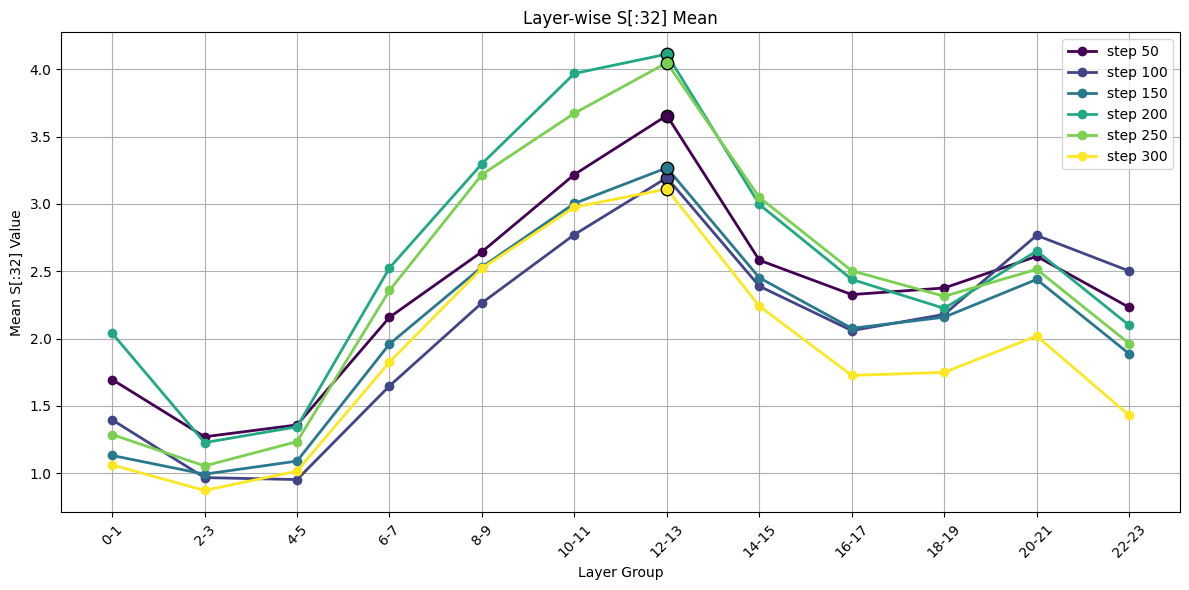

In [10]:
# 存储每个step的折线值（每两个layer一组）
all_curves = {}
max_points = []  # (x_index, y_value, step) for trend line
for step in checkpoint_steps:
    state_dict = torch.load(base_path + f"/checkpoint-{step}/named_grads_s_only.pt")
    # 每个block的平均值（长度为24）
    block_avg_values = []

    for i in range(24):
        prefix = f"transformer_blocks.{i}.attn"
        values = []
        for key, value in state_dict.items():
            if key.startswith(prefix):
                val = value["S"][:32].mean().item()
                values.append(val)
        if values:
            block_avg = np.mean(values)
            block_avg_values.append(block_avg)
        else:
            block_avg_values.append(np.nan)  # 占位

    # === 每两个 layer 合并求平均，生成12个bar ===
    line_means = []
    
    
    for i in range(0, 24, 2):
        mean_val = np.nanmean([block_avg_values[i], block_avg_values[i+1]])
        line_means.append(mean_val)
    all_curves[step] = line_means
    # 找最大值的位置
    max_idx = int(np.nanargmax(line_means))
    max_val = line_means[max_idx]
    max_points.append((max_idx, max_val, step))

# 横轴 label
x_ticks = [f"{i}-{i+1}" for i in range(0, 24, 2)]

# 开始画图
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(all_curves)))

# 画每条step曲线 + 最大值点
for (step, curve), color in zip(all_curves.items(), colors):
    plt.plot(range(len(curve)), curve, marker='o', label=f"step {step}", linewidth=2, color=color)
    # 标出最大值点
    max_idx = int(np.nanargmax(curve))
    max_val = curve[max_idx]
    plt.scatter(max_idx, max_val, color=color, s=80, edgecolors='black', zorder=5)

# # 加一条最大值趋势线（按step顺序）
# max_x = [pt[0] for pt in max_points]
# max_y = [pt[1] for pt in max_points]
# plt.plot(max_x, max_y, linestyle='--', color='red', linewidth=2.5, label="Max value trend")

# 标注和装饰
plt.xticks(ticks=range(len(x_ticks)), labels=x_ticks, rotation=45)
plt.title("Layer-wise S[:32] Mean")
plt.xlabel("Layer Group")
plt.ylabel("Mean S[:32] Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.savefig(f"{base_path}/attn_lineplot_with_max_trend.png")
plt.show()